In [1]:
#This imports all the packages you need (you might not use some of them)
#Please run this first
#we will need this for array operation
import numpy as np
#we will need this for plots
import matplotlib.pyplot as plt
#We will need this to calculate factorial on array
import scipy.misc as spm
#We will need this to do calculations related to distribution
import scipy.stats as spst

#We will need this to calculate factorial on array
import scipy.special as spsp

#Sympy
import sympy 

#simpy
!pip install simpy
import simpy

xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.3 which is incompatible.
xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.23.0 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Exercise 1 [28 Points]

In small company has 10 machines. At the beginning the machines are all working normally. For every machine, after $\Delta t$ hours of operating, the machine will break down. $\Delta t \sim Exp(\lambda=0.1)$.

If a machine breaks down, this machine will immediately be taken to the maintenance room. The maintenance room can only fix one machine at a time. The machines will be fixed following FIFO. The time it takes to fix the machine follows $Exp(\lambda=1)$.

After the machine is fixed, it will be sent back to the operation room immediately to perform tasks.  After $\Delta t$ hours of operating, the machine will break down again. Again, $\Delta t \sim Exp(\lambda=0.1)$.


##Q1. [14 points]

Simulate the system using `simpy`. The simulation should stop when the number of operating machines goes below 7. 

* Run the system 1000 times. Plot the distribution of the time it takes for the number of operating machines to go below 7.


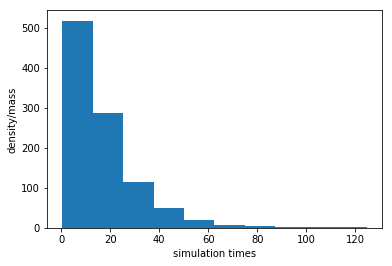

16.342321064445972

In [2]:
#below7 is an event that will be triggered when the number of machine goes below 7
#repairman handles the maintanance of the machines
#breaktime tracks the time when the simulation stops
#TotalM tracks the total number of operating machines.

#optional function [depends on how you implement the system, you might not need this function]
#def initialization(env,below7,repairman,breaktime,TotalM):
 

#This function models the operation of each machine
def operating(env,below7,repairman,breaktime,TotalM):
  
    lmbda=0.1
    #print("The number of operating machines now is", len(TotalM))
    while True:
        time_until_break = np.min(-1/lmbda*np.log(np.random.rand(len(TotalM))))
        yield env.timeout(time_until_break)
        TotalM.pop()
        #print("The number of operating machines now is", len(TotalM))
        if (len(TotalM) < 7):
            below7.succeed()
            #print('The number of operating machines goes below 7.')
            breaktime.append(env.now)
        env.process(maintenance(env,repairman,TotalM))

#more functions

def maintenance(env,repairman,TotalM):
    #print("The number of operating machines at the start of service process is", len(TotalM))
    rqt=repairman.request()
    yield rqt
    lmbda1 = 1
    repair_time = -1/lmbda1*np.log(np.random.rand())
    yield env.timeout(repair_time)
    repairman.release(rqt)
    TotalM.append(1)
    #print("A machine is repaired and the number of working machines now is", len(TotalM))
  
  
#define system simulation    
def system():
    env = simpy.Environment()
    repairman = simpy.Resource(env)
    breaktime = [env.now]
    TotalM = [1,1,1,1,1,1,1,1,1,1]
    below7 = env.event()
    env.process(operating(env,below7,repairman,breaktime,TotalM))
    env.run(until = below7)
    #print("The simulation has terminated!", breaktime)
    return breaktime[1] - breaktime[0]
  
simu_times = [system() for i in range(1000)]
plt.hist(simu_times)
plt.xlabel("simulation times")
plt.ylabel("density/mass")
plt.show()
np.mean(simu_times)

##Q2.  [14 points]

The maintenance room will shut down for 0.2 hours after every hour. During this time, the repairmen will not fix any machine. After the maintenance room reopens, the repairmen will resume fixing the machines. If at the time of break, the repairmen have taken $x'$ period of time to fix a machine and the amount of the time to fix the machine is $x$, the machine will now need $x-x'$ amount of time to get fixed.

* Run the system 1000 times. Plot the distribution of the time it takes for the number of operating machines to go below 7.

[hint: you might find defining the maintenance room as a preemptive resource helpful]

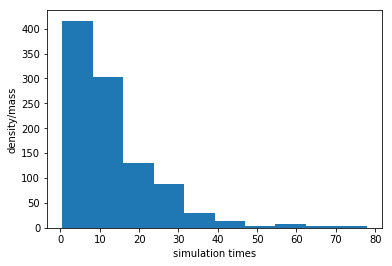

13.154434698604293

In [3]:
#below7 is an event that will be triggered when the number of machine goes below 7
#repairman handles the maintanance of the machines
#breaktime tracks the time when the simulation stops
#TotalM tracks the total number of operating machines.

#optional function [depends on how you implement the system, you might not need this function]
#def initialization(env,below7,repairman,breaktime,TotalM):
 

#This function models the operation of each machine
def operating(env,below7,repairman,breaktime,TotalM):
    lmbda=0.1
    env.process(shut(env,repairman))
    #print("The initial number of operating machines is", len(TotalM))
    i = 0
    while True:
        i = i + 1
        time_until_break = np.min(-1/lmbda*np.log(np.random.rand(len(TotalM))))
        yield env.timeout(time_until_break)
        TotalM.pop()
        #print("The number of operating machines now is", len(TotalM))
        if (len(TotalM) < 7):
            below7.succeed()
            #print('The number of operating machines goes below 7.')
            breaktime.append(env.now)
        priority = 0
        preempt = False
        env.process(maintenance(env,repairman,TotalM, priority, preempt, i))

#more functions
def shut(env,repairman):
  
    while True:
        # maintenance room works for one hour
        #print("The maintenance room starts to work at", env.now)
        yield env.timeout(1)
        # shut down for 0.2 hours
        #print("The maintenance room is about to close at", env.now)
        shut_down = repairman.request(priority=-2, preempt=True)
        yield shut_down
        yield env.timeout(0.2)
        #print("The shut-down is over and the maintenance room is about to reopen at", env.now)
        repairman.release(shut_down)

def maintenance(env,repairman,TotalM,priority,preempt, i):

    lmbda1 = 1
    repair_time = -1/lmbda1*np.log(np.random.rand())
    while True:
        try:
            #print("The number of operating machines at the start of service process is", len(TotalM))
            rqt=repairman.request(priority=priority, preempt=preempt)
            yield rqt
            # record the time when rqt starts to be served(the broken machine starts to be repaired)
            start_time = env.now
            #print("The remaining repair time of the {}th broken machine is {}".format(i, repair_time))
            #print("The time when the {}th broken machine starts to be repaired is {}".format(i,start_time))
            yield env.timeout(repair_time)
            repairman.release(rqt)
            TotalM.append(1)
            #print("The time when the {}th broken machine finishes to be repaired is {}".format(i,env.now))
            #print("A machine is repaired and the number of working machines now is", len(TotalM))
            env.exit()
            
        except simpy.Interrupt as inter:
            if type(inter.cause)==simpy.resources.resource.Preempted:
                priority = -1
                elapsed_time = env.now - start_time
                #print("The time when the repairment of the {}th machine is interrupted is {}".format(i,env.now))
                #print("The repairment of the {}th machine has taken {}".format(i,elapsed_time))
                repair_time = repair_time - elapsed_time

#define system simulation    
def system():
  
    env = simpy.Environment()
    repairman = simpy.PreemptiveResource(env)
    breaktime = [env.now]
    TotalM = [1,1,1,1,1,1,1,1,1,1]
    below7 = env.event()
    env.process(operating(env,below7,repairman,breaktime,TotalM))
    env.run(until = below7)
    #print("The simulation has terminated!", breaktime)
    return breaktime[1] - breaktime[0]

simu_times = [system() for i in range(1000)]
plt.hist(simu_times)
plt.xlabel("simulation times")
plt.ylabel("density/mass")
plt.show()
np.mean(simu_times)

#Exercise 2 [32 Points]



##Setting

A server is operates to handle the homogeneous tasks. 

Tasks arrive following a non-homonogeous Poisson process with $\lambda=t\%5$ if $t\%10<5$ and $\lambda=5-t\%5$ if $t\%10>=5$.

##Q1 [8 Points]
* Visualize the arrival rate between 0 and 50.
* Based on thinning method, generate the arrival times between 0 and 50. Do not use `simpy`. 
* Plot the distribution of the arrival times.

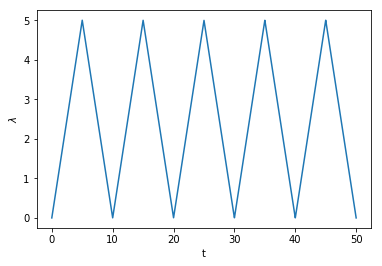

In [4]:
T=50
t = np.linspace(0,T,5000)
lmbda = np.empty(len(t))
lmbda[t%10<5] = t[t%10<5]%5
lmbda[t%10>=5] = 5-t[t%10>=5]%5
plt.plot(t,lmbda)
plt.xlabel("t")
plt.ylabel("$\lambda$")
plt.show()

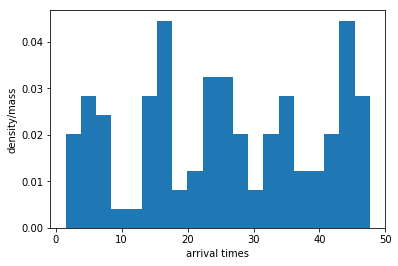

In [5]:
Lmbda_max = np.max(lmbda)
def ArrivalTimes():
    #stores the accepted arrivals
    arrival_times = np.empty(0)
    t = (-1/Lmbda_max)*np.log(np.random.rand())

    while t<T:
        if t%10<5:
            AR = (t%5)/Lmbda_max
        else:
            AR = (5-t%5)/Lmbda_max

        if (np.random.rand()<AR):
            arrival_times = np.append(arrival_times, t)

        t = t + (-1/Lmbda_max)*np.log(np.random.rand())
    return arrival_times

arrival_times = ArrivalTimes()
plt.hist(arrival_times,density=True,bins=20)
plt.xlabel("arrival times")
plt.ylabel("density/mass")
plt.show()

###Q2 [8 Points]

Now, assume that the service time follows a uniform distribution between 1 and 3. The tasks follows FIFO and handled by the single server.


Use `simpy` to simulate the system until t=50. Notice that you have generated the arrival times, it is very simple for you to generate the inter-arrival times. 

* Run the system 500 times and plot the distribution of the average time a task spent in the system for all the tasks that are completed.
* Compute the 95% confidence interval for the population mean of the average time in the system.
* Compute the width of the confidence interval for the population mean of the average time in the system.


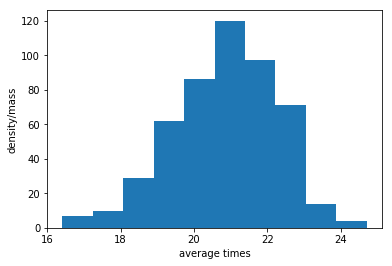

The 95% confidence interval is [20.75268319721749, 20.99917611064016]
The width of the confidence interval is 0.24649291342267077


In [6]:
def arrival(env,server,inter_arrivals,servicetimes,departtimes):
    for i in range(len(inter_arrivals)):
        yield env.timeout(inter_arrivals[i])
        env.process(service(env,server,servicetimes,departtimes,i))

def service(env,server,servicetimes,departtimes,i):
    rqt=server.request()
    yield rqt
    yield env.timeout(servicetimes[i])
    server.release(rqt)
    departtimes.append(env.now)

def system_q2():

    env=simpy.Environment()
    server=simpy.Resource(env)
    arrival_times = ArrivalTimes()
    inter_arrivals = np.diff(np.insert(arrival_times,0,0))
    num_arrivals = len(arrival_times)
    u = np.random.rand(num_arrivals)
    servicetimes=2*u+1
    departtimes=[]
    env.process(arrival(env,server,inter_arrivals,servicetimes,departtimes))
    env.run(until=50)
    departtimes = np.array(departtimes)
    average_time=np.mean(departtimes-arrival_times[0:len(departtimes)])
  
    return average_time

N=500
ATs=[system_q2() for i in range(N)]
ATs = np.array(ATs)
plt.hist(ATs)
plt.xlabel("average times")
plt.ylabel("density/mass")
plt.show()
mean=np.mean(ATs)
std=np.std(ATs,ddof=1)
lower=mean-1.96*std/N**0.5
upper=mean+1.96*std/N**0.5
print("The 95% confidence interval is [{}, {}]".format(lower,upper))
print("The width of the confidence interval is", upper-lower)

##Q3 [8 points]

Apply antithetic method to the service time.  

* Run the original system 250 times and anti-thetic part 250 times and plot the distribution of the average time a task spent in the system  for all the tasks that are completed.
* Compute the 95% confidence interval for the population mean of the average time in the system.
* Compute the width of the confidence interval for the population mean of the average time in the system.




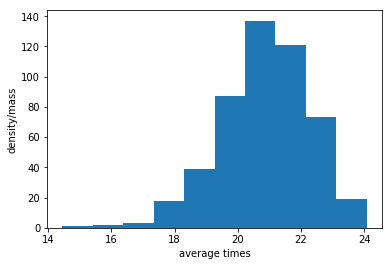

The 95% confidence interval is [20.766021779294604, 20.9686391666104]
The width of the confidence interval is 0.20261738731579726


In [7]:
def arrival(env,server,inter_arrivals,servicetimes,departtimes):
    for i in range(len(inter_arrivals)):
        yield env.timeout(inter_arrivals[i])
        env.process(service(env,server,servicetimes,departtimes,i))

def service(env,server,servicetimes,departtimes,i):
    rqt=server.request()
    yield rqt
    yield env.timeout(servicetimes[i])
    server.release(rqt)
    departtimes.append(env.now)

def system_q3(u, arrival_times):

    env=simpy.Environment()
    server=simpy.Resource(env)
    inter_arrivals = np.diff(np.insert(arrival_times,0,0))
    num_arrivals = len(arrival_times)
    servicetimes=2*u+1
    departtimes=[]
    env.process(arrival(env,server,inter_arrivals,servicetimes,departtimes))
    env.run(until=50)
    departtimes = np.array(departtimes)
    average_time=np.mean(departtimes-arrival_times[0:len(departtimes)])
  
    return average_time

def anti():
    arrival_times_original = ArrivalTimes()
    arrival_times_anti = ArrivalTimes()
    num = np.max([len(arrival_times_original), len(arrival_times_anti)])
    u = np.random.rand(num)

    if num == len(arrival_times_original):
        u_original = u
        u_anti = 1 - u_original
        u_anti = u_anti[0:len(arrival_times_anti)]
    else:
        u_anti = u
        u_original = 1 - u_anti
        u_original = u_original[0:len(arrival_times_original)]

    at_odd = system_q3(u_original, arrival_times_original)
    at_even = system_q3(u_anti, arrival_times_anti)
  
    return at_odd, at_even, (at_odd+at_even)/2


N=250
returns=[anti() for i in range(N)]
at1 = [item[0] for item in returns]
at2 = [item[1] for item in returns]
ATs = np.append(np.array(at1), np.array(at2))
y = [item[2] for item in returns]
y = np.array(y)
plt.hist(ATs)
plt.xlabel("average times")
plt.ylabel("density/mass")
plt.show()
mean=np.mean(y)
std=np.std(y,ddof=1)
lower=mean-1.96*std/N**0.5
upper=mean+1.96*std/N**0.5
print("The 95% confidence interval is [{}, {}]".format(lower,upper))
print("The width of the confidence interval is", upper-lower)



## Q4. [8 Points]

Use the number of arrivals as control variates to reduce the variance.

* Run the system 500 times and plot the distribution of the average time a task spent in the system for all the tasks that are completed.
* Compute the 95% confidence interval for the population mean of the average time in the system.
* Compute the width of the confidence interval for the population mean of the average time in the system.


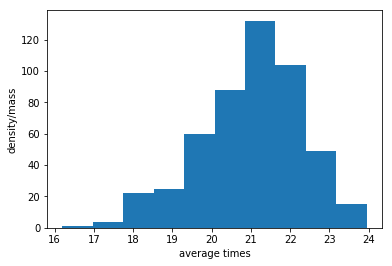

The 95% confidence interval is [20.863644829555017, 21.090500620384542]
The width of the confidence interval is 0.226855790829525


In [8]:
def arrival(env,server,inter_arrivals,servicetimes,departtimes):
    for i in range(len(inter_arrivals)):
        yield env.timeout(inter_arrivals[i])
        env.process(service(env,server,servicetimes,departtimes,i))

def service(env,server,servicetimes,departtimes,i):
    rqt=server.request()
    yield rqt
    yield env.timeout(servicetimes[i])
    server.release(rqt)
    departtimes.append(env.now)

def system_q4():

    env=simpy.Environment()
    server=simpy.Resource(env)
    arrival_times = ArrivalTimes()
    inter_arrivals = np.diff(np.insert(arrival_times,0,0))
    num_arrivals = len(arrival_times)
    u = np.random.rand(num_arrivals)
    servicetimes=2*u+1
    departtimes=[]
    env.process(arrival(env,server,inter_arrivals,servicetimes,departtimes))
    env.run(until=50)
    departtimes = np.array(departtimes)
    average_time=np.mean(departtimes-arrival_times[0:len(departtimes)])
  
    return average_time, num_arrivals

N = 500
returns = [system_q4() for i in range(N)]
ATs = np.array([item[0] for item in returns])
z = np.array([item[1] for item in returns])
c=-np.cov(ATs,z,ddof=1)[0,1]/np.var(z,ddof=1)
y=ATs+c*(z-125)
plt.hist(ATs)
plt.xlabel("average times")
plt.ylabel("density/mass")
plt.show()
mean=np.mean(y)
std=np.std(y,ddof=1)
lower=mean-1.96*std/N**0.5
upper=mean+1.96*std/N**0.5
print("The 95% confidence interval is [{}, {}]".format(lower,upper))
print("The width of the confidence interval is", upper-lower)